<a href="https://www.kaggle.com/code/tct221212/nhom-5?scriptVersionId=183778016" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/traffic-prediction-dataset/traffic.csv


In [2]:
traffic_data=pd.read_csv('/kaggle/input/traffic-prediction-dataset/traffic.csv')

traffic_data.head()


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
print('before dropping ',traffic_data.shape[0])
traffic_data.drop_duplicates(keep="first", inplace=True) 
print('after dropping ',traffic_data.shape[0])

before dropping  48120
after dropping  48120


In [4]:
if(traffic_data.isnull().sum().sum()==0):
    print('no missing values in train')
else:
    traffic_data.fillna(method='ffill',inplace=True)

no missing values in train


In [5]:
print('before converting :',traffic_data['DateTime'].dtype)
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

before converting : object


In [6]:
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB


In [7]:
# Exploring more features  
traffic_data["Year"]= traffic_data['DateTime'].dt.year  
traffic_data["Month"]= traffic_data['DateTime'].dt.month  
traffic_data["Date_no"]= traffic_data['DateTime'].dt.day  
traffic_data["Hour"]= traffic_data['DateTime'].dt.hour  
#traffic_data["Day"]= traffic_data.DateTime.dt.strftime("%A")

In [8]:
traffic_data.head()

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4


Text(0.5, 0, 'DateTime')

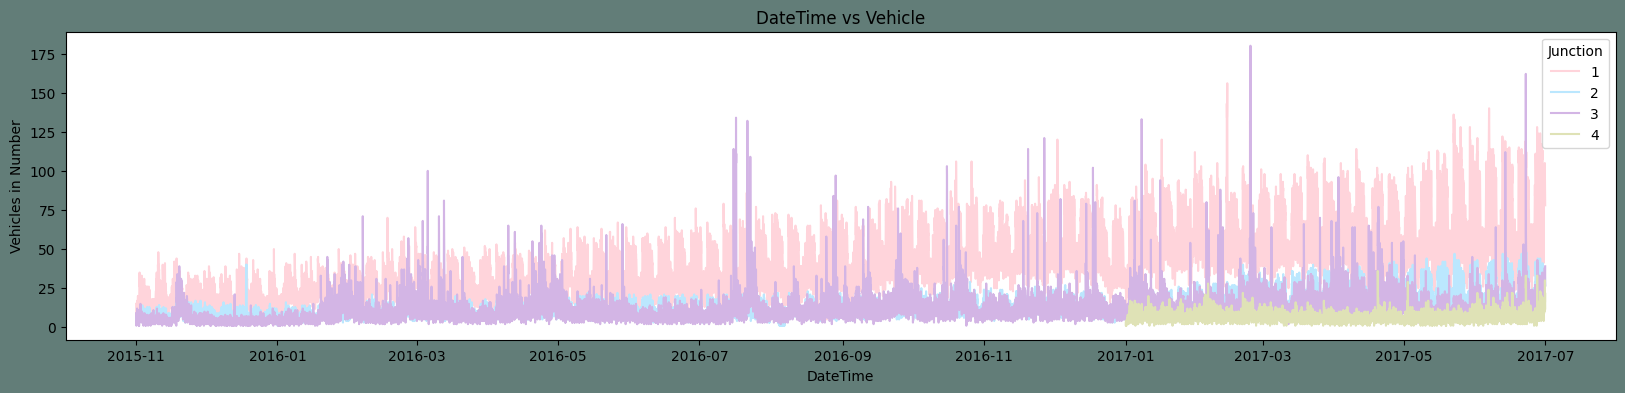

In [9]:
# time series plot
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")  
time_series=sns.lineplot(x=traffic_data['DateTime'],y="Vehicles",data=traffic_data, hue="Junction", palette=colors)  
time_series.set_title("DateTime vs Vehicle")  
time_series.set_ylabel("Vehicles in Number")  
time_series.set_xlabel("DateTime")

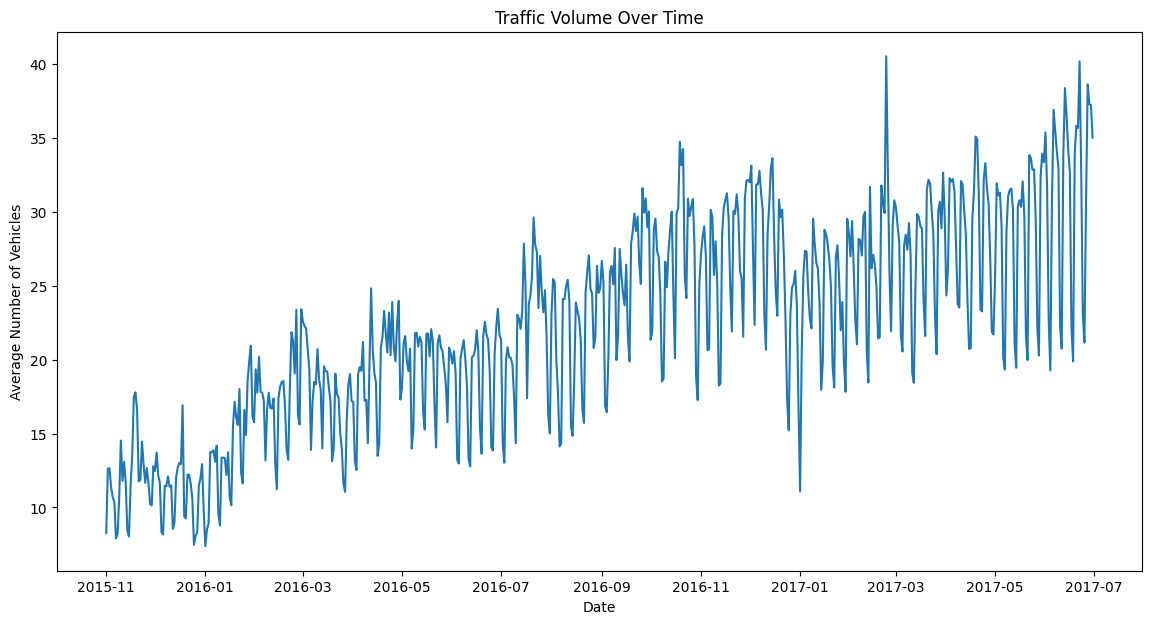

In [10]:
plt.figure(figsize=(14, 7))
traffic_data_resampled = traffic_data.set_index('DateTime').resample('D').mean()
sns.lineplot(data=traffic_data_resampled, x=traffic_data_resampled.index, y='Vehicles')
plt.title('Traffic Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Average Number of Vehicles')
plt.show()

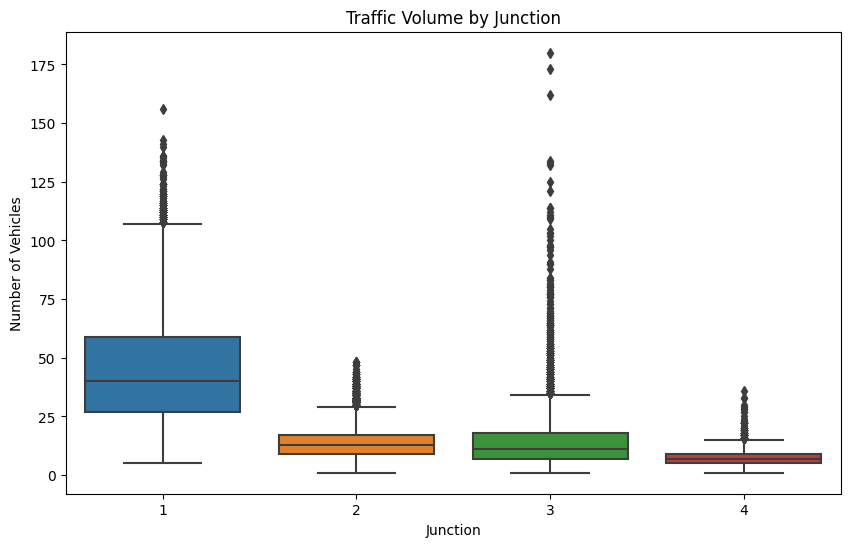

In [11]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Junction', y='Vehicles', data=traffic_data)
plt.title('Traffic Volume by Junction')
plt.xlabel('Junction')
plt.ylabel('Number of Vehicles')
plt.show()

In [12]:

traffic_data['HourOfDay'] = traffic_data['DateTime'].dt.hour
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.day_name()

In [13]:
# Aggregate data to find mean traffic volume for each hour of the day

hourly_traffic = traffic_data.groupby('HourOfDay')['Vehicles'].mean().reset_index()

# Aggregate data to find mean traffic volume for each day of the week

weekly_traffic = traffic_data.groupby('DayOfWeek')['Vehicles'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()

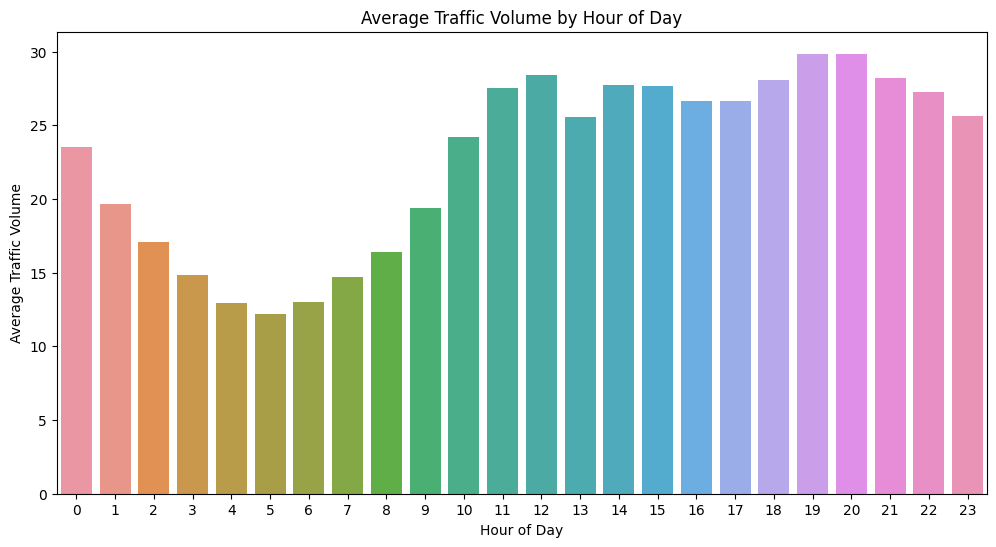

In [14]:
# Plotting the hourly traffic volume

plt.figure(figsize=(12, 6))
sns.barplot(x='HourOfDay', y='Vehicles', data=hourly_traffic)
plt.title('Average Traffic Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Volume')
plt.xticks(np.arange(0, 24, 1))
plt.show()

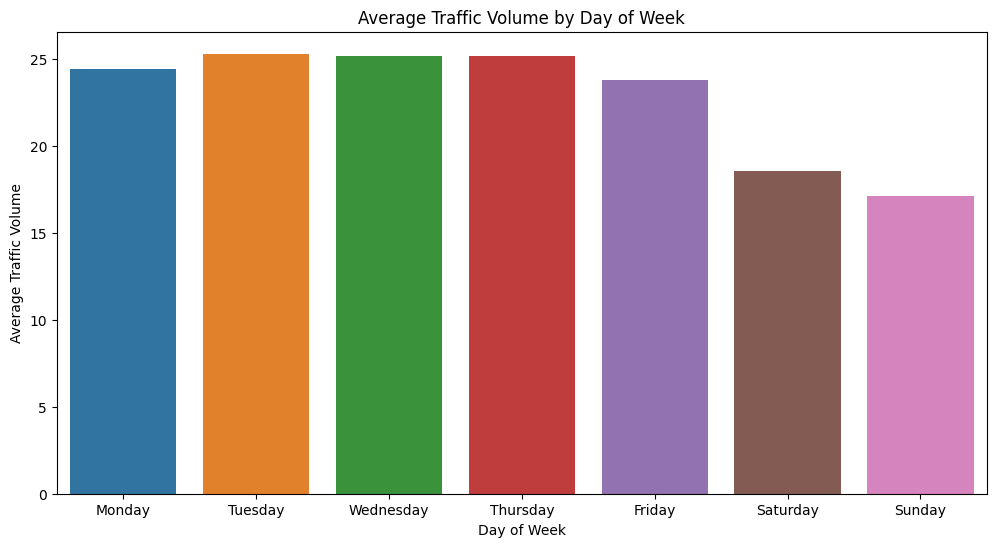

In [15]:
# Plotting the daily traffic volume

plt.figure(figsize=(12, 6))
sns.barplot(x='DayOfWeek', y='Vehicles', data=weekly_traffic)
plt.title('Average Traffic Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Traffic Volume')
plt.show()

In [16]:
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data['Hour'] = traffic_data['DateTime'].dt.hour
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.dayofweek

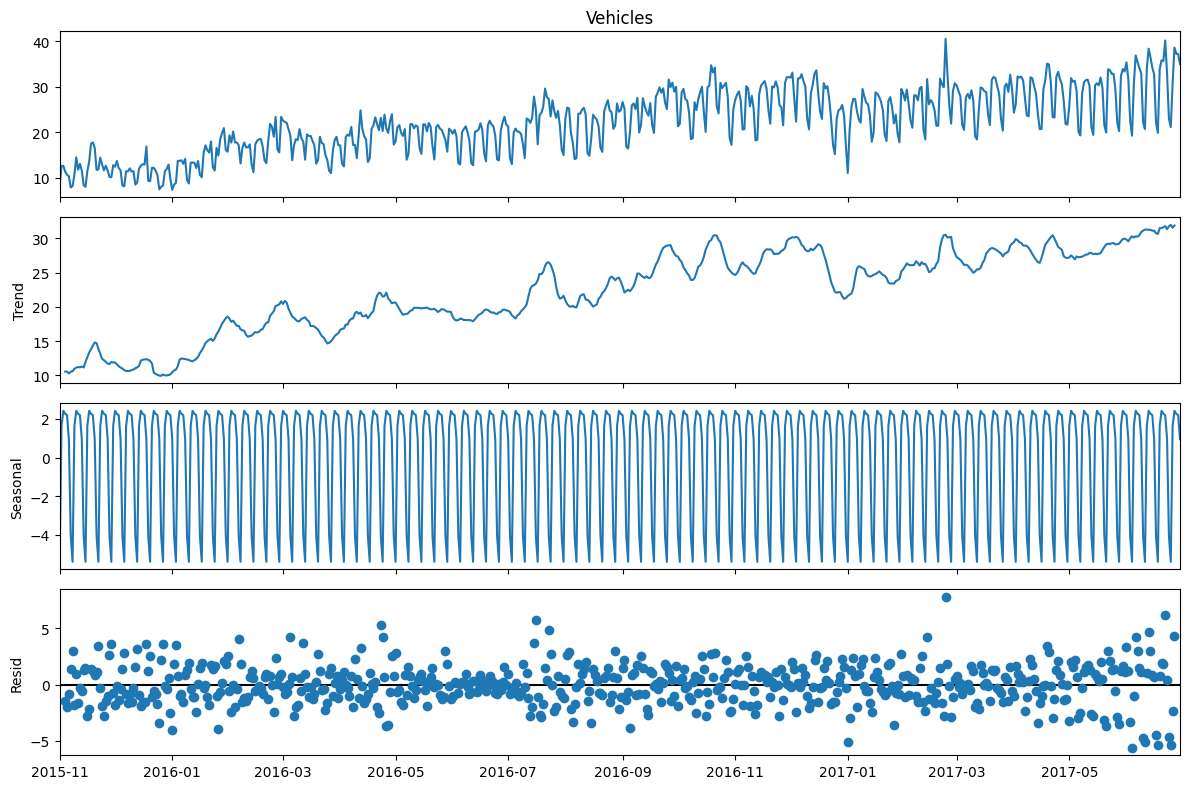

In [17]:
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data.set_index('DateTime', inplace=True)

# Resample the data to get daily averages
daily_traffic = traffic_data.resample('D').mean()

# Perform the seasonal decomposition
result = seasonal_decompose(daily_traffic['Vehicles'], model='additive', period=7)


plt.rcParams['figure.figsize'] = [12, 8]

result.plot()
plt.tight_layout()
plt.show()

In [18]:
traffic_data = pd.read_csv('/kaggle/input/traffic-prediction-dataset/traffic.csv')

# Convert 'DateTime' to datetime and create new time-related features
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])
traffic_data['HourOfDay'] = traffic_data['DateTime'].dt.hour
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.dayofweek  # Monday=0, Sunday=6

# Calculate the correlation matrix
correlation_matrix = traffic_data[['HourOfDay', 'DayOfWeek', 'Vehicles']].corr()

print(correlation_matrix)

              HourOfDay     DayOfWeek  Vehicles
HourOfDay  1.000000e+00  6.442124e-18  0.219938
DayOfWeek  6.442124e-18  1.000000e+00 -0.126027
Vehicles   2.199377e-01 -1.260265e-01  1.000000


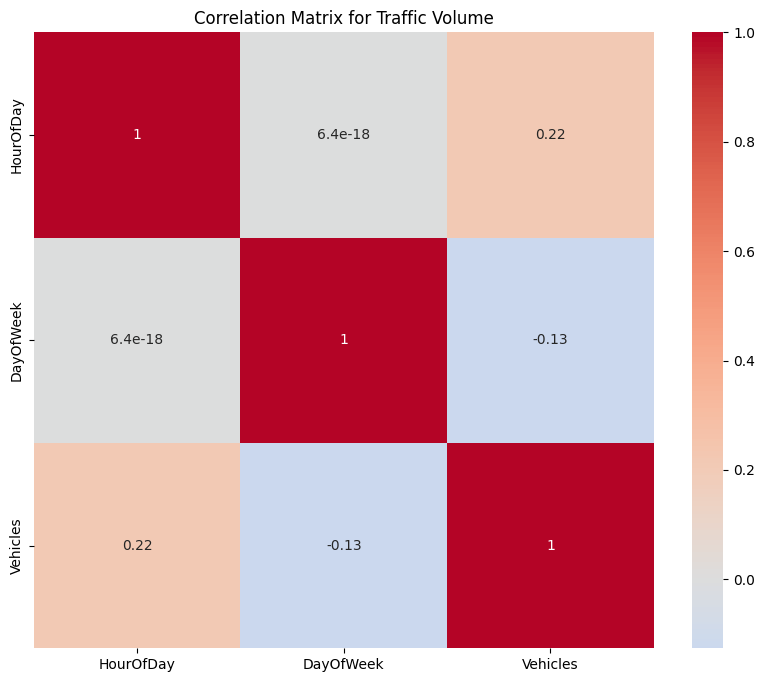

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for Traffic Volume')
plt.show()

In [20]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay

2024-06-16 08:23:46.924367: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 08:23:46.924477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 08:23:47.048080: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [21]:
data=pd.read_csv("/kaggle/input/traffic-prediction-dataset/traffic.csv")
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [22]:
data['DateTime']=pd.to_datetime(data['DateTime'])

data["Year"]=data['DateTime'].dt.year

data["Month"]=data['DateTime'].dt.month

data["Date_no"]=data['DateTime'].dt.day

data["Hour"]=data['DateTime'].dt.hour

data["Day"]= data['DateTime'].dt.strftime("%A")
data

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday
...,...,...,...,...,...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194,2017,6,30,19,Friday
48116,2017-06-30 20:00:00,4,30,20170630204,2017,6,30,20,Friday
48117,2017-06-30 21:00:00,4,16,20170630214,2017,6,30,21,Friday
48118,2017-06-30 22:00:00,4,22,20170630224,2017,6,30,22,Friday


In [23]:
data = data[(data['Junction'] == 1)]
def Normalize(df,col):
    average = df[col].mean() #Tính giá trị trung bình của cột col trong DataFrame df.
    stdev = df[col].std()#Tính độ lệch chuẩn của cột col.
    df_normalized = (df[col] - average) / stdev #Chuẩn hóa cột col bằng cách trừ đi giá trị trung bình và chia cho độ lệch chuẩn.
    df_normalized = df_normalized.to_frame() #Chuyển Series df_normalized thành DataFrame.
    return df_normalized, average, stdev #rả về DataFrame đã chuẩn hóa, giá trị trung bình và độ lệch chuẩn của cột ban đầu.

def Difference(df,col, interval):
    diff = [] #Khởi tạo một danh sách rỗng để lưu trữ các giá trị khác biệt.
    for i in range(interval, len(df)): #Lặp qua các chỉ số của DataFrame từ interval đến cuối DataFrame.
        value = df[col][i] - df[col][i - interval] #Tính sự khác biệt giữa giá trị tại vị trí i và giá trị tại vị trí i - interval.
        diff.append(value) #Thêm giá trị khác biệt vào danh sách diff.
    return diff

Lọc dữ liệu:

Chỉ giữ lại các hàng có giá trị của cột 'Junction' bằng 1 trong DataFrame data.
Chuẩn hóa dữ liệu:

Hàm Normalize chuẩn hóa giá trị của một cột trong DataFrame bằng cách trừ đi giá trị trung bình và chia cho độ lệch chuẩn, trả về DataFrame đã chuẩn hóa cùng với giá trị trung bình và độ lệch chuẩn của cột ban đầu.
Tính sự khác biệt:

Hàm Difference tính sự khác biệt giữa các giá trị trong một cột theo khoảng thời gian interval, trả về danh sách các giá trị khác biệt.

In [24]:
df_N, av, std = Normalize(data, "Vehicles") # chuan hoa du lieu trả về ba giá trị: DataFrame chuẩn hóa (df_N), giá trị trung bình (av), và độ lệch chuẩn (std).
Diff = Difference(df_N, col="Vehicles", interval=(24*7)) #Gọi hàm Difference với DataFrame chuẩn hóa (df_N), cột "Vehicles", và khoảng thời gian (24 giờ x 7 ngày = 168 giờ).
df_N = df_N[24*7:] #Bỏ qua 168 hàng đầu tiên của DataFrame chuẩn hóa df_N.
df_N.columns = ["Norm"]
df_N["Diff"]= Diff
df = df_N["Diff"].dropna() #Loại bỏ các giá trị NaN trong cột "Diff".
df = df.to_frame()
df.head()

,Diff
168,-0.086925
169,0.130387
170,0.043462
171,0.043462
172,0.043462


Chuẩn hóa dữ liệu:

Chuẩn hóa cột "Vehicles" trong DataFrame data để có giá trị trung bình bằng 0 và độ lệch chuẩn bằng 1.
Tính sự khác biệt:

Tính sự khác biệt giữa các giá trị trong cột "Vehicles" theo khoảng thời gian một tuần (168 giờ).
Xử lý DataFrame:

Bỏ qua 168 hàng đầu tiên của DataFrame chuẩn hóa để đồng bộ với danh sách các giá trị khác biệt.
Đổi tên cột và thêm cột chứa các giá trị khác biệt vào DataFrame.
Loại bỏ các giá trị NaN và chuyển đổi Series thành DataFrame.

In [25]:
def Split_data(df):
    training_size = int(len(df)*0.80) # Lấy 80% số lượng hàng để làm kích thước tập huấn luyện 
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]  
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1) #Chuyển đổi tập huấn luyện train,test từ DataFrame sang mảng numpy và thay đổi hình dạng thành mảng có một cột
    return train, test

df_train, df_test = Split_data(df)

Chia dữ liệu:

Chia dữ liệu thành hai tập: tập huấn luyện (80% dữ liệu) và tập kiểm tra (20% dữ liệu).
Chuyển đổi dữ liệu:

Chuyển đổi dữ liệu từ DataFrame thành mảng numpy và thay đổi hình dạng thành mảng có một cột.
Trả về kết quả:

Trả về tập huấn luyện và tập kiểm tra để sử dụng trong các bước tiếp theo của quy trình phân tích hoặc huấn luyện mô hình.

In [26]:
def TnF(df):
    end_len = len(df) #Số lượng phần tử trong DataFrame df
    X = [] #Danh sách để lưu trữ các mẫu đầu vào.
    y = [] #Danh sách để lưu trữ các giá trị đích.
    steps = 32 #Số lượng bước thời gian để sử dụng cho mỗi mẫu đầu vào (ở đây là 32 bước).
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0]) #Lấy 32 giá trị trước đó làm mẫu đầu vào
        y.append(df[i, 0]) #Lấy giá trị tại vị trí hiện tại làm giá trị đích
    X, y = np.array(X), np.array(y)
    return X ,y

def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

X_train, y_train = TnF(df_train)
X_test, y_test = TnF(df_test)
X_train, X_test = FeatureFixShape(X_train, X_test)

Tạo các mẫu đầu vào và giá trị đích:

TnF: Tạo các mẫu đầu vào và giá trị đích từ DataFrame, sử dụng 32 bước thời gian cho mỗi mẫu.
Thay đổi hình dạng dữ liệu:

FeatureFixShape: Thay đổi hình dạng dữ liệu đầu vào thành (số lượng mẫu, số bước thời gian, 1), phù hợp với định dạng đầu vào của các mô hình học sâu.

In [27]:
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

def MAE_Value(test,predicted):
    mae = mean_absolute_error(test, predicted)
    print("The MAE is {}.".format(mae))
    return mae
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5))
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted,label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [28]:

def GRU_model(X_Train, y_Train, X_Test, y_Test):
    
    #The GRU model 
    model_GRU = Sequential() #Khởi tạo một mô hình tuần tự.
    model_GRU.add(GRU(units=100, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh')) #Thêm một lớp GRU với 100 đơn vị đầu ra, trả về chuỗi và hàm kích hoạt là tanh.
    model_GRU.add(Dropout(0.2)) #Thêm lớp dropout với tỷ lệ dropout là 0.2, giúp tránh việc quá mức phù hợp và giảm overfitting.
    model_GRU.add(GRU(units=20, input_shape=(X_Train.shape[1],1), activation='tanh')) #Thêm một lớp GRU với 20 đơn vị đầu ra, không trả về chuỗi và hàm kích hoạt là tanh
    model_GRU.add(Dropout(0.2))
    model_GRU.add(Dense(units=1))#Thêm một lớp dense với 1 đơn vị đầu ra.

    #Compiling the model
    model_GRU.compile(optimizer=SGD(momentum=0.9),loss='mean_squared_error') #Sử dụng trình tối ưu hóa SGD Sử dụng hàm mất mát là mean squared error (MSE).
    model_GRU.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120)
    pred_GRU= model_GRU.predict(X_Test)
    return pred_GRU

In [29]:
Pred_GRU = GRU_model(X_train,y_train,X_test,y_test) #huấn luyện và dự đoán của mô hình GRU trên tập dữ liệu,


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0700 - val_loss: 0.0643
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0499 - val_loss: 0.0607
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0495 - val_loss: 0.0595
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0465 - val_loss: 0.0588
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0481 - val_loss: 0.0577
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0478 - val_loss: 0.0576
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0455 - val_loss: 0.0572
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0447 - val_loss: 0.0568
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0450 - val_loss: 0.0578
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0460 - val_loss: 0.0564
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0460 - val_loss: 0.0563
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0441 - val_l

The root mean squared error is 0.2348944149536555.
The MAE is 0.1693994984688441.


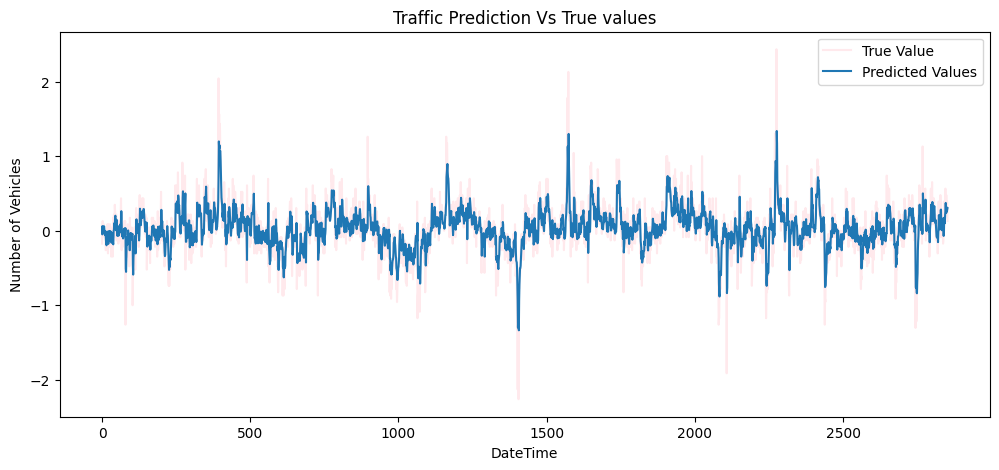

In [30]:
RMSE_GRU = RMSE_Value(y_test, Pred_GRU)
MAE_GRU = MAE_Value(y_test, Pred_GRU)
PredictionsPlot(y_test, Pred_GRU, 0)


In [31]:
def LSTM_model(X_Train, y_Train, X_Test, y_Test): 
    
    #The LSTM model 
    model_LSTM = Sequential()
    model_LSTM.add(LSTM(units=100, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh')) #hêm một lớp LSTM với 100 đơn vị đầu ra, trả về chuỗi, và hàm kích hoạt là tanh.
    model_LSTM.add(Dropout(0.2)) #Thêm một lớp dropout với tỷ lệ dropout là 0.2 để giảm overfitting.
    model_LSTM.add(LSTM(units=20, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(Dense(units=1)) # thêm một lớp dense với 1 đơn vị đầu ra.
    
    #Compiling the model
    model_LSTM.compile(optimizer=SGD(momentum=0.9),loss='mean_squared_error') #Sử dụng trình tối ưu hóa SGD Sử dụng hàm mất mát là mean squared error (MSE).
    model_LSTM.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120)
    pred_LSTM = model_LSTM.predict(X_Test)
    return pred_LSTM

In [32]:
Pred_LSTM = LSTM_model(X_train,y_train,X_test, y_test)


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0829 - val_loss: 0.0843
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0624 - val_loss: 0.0806
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0573 - val_loss: 0.0780
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0564 - val_loss: 0.0753
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0554 - val_loss: 0.0727
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0531 - val_loss: 0.0712
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0556 - val_loss: 0.0704
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0526 - val_loss: 0.0685
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0528 - val_loss: 0.0673
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0530 - val_loss: 0.0664
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0526 - val_loss: 0.0656
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0483 - val_lo

The root mean squared error is 0.23666490793207487.
The MAE is 0.17062768489409555.


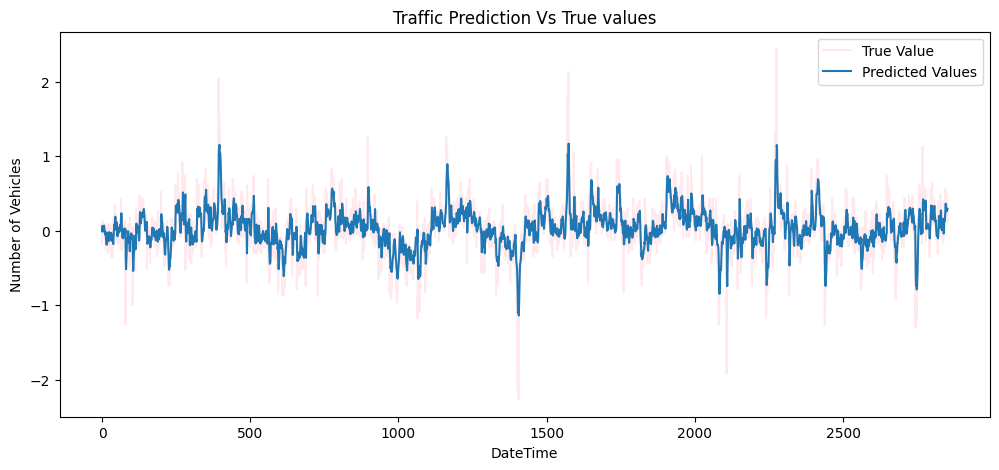

In [33]:
RMSE_LSTM = RMSE_Value(y_test, Pred_LSTM)
MAE_LSTM = MAE_Value(y_test, Pred_LSTM)
PredictionsPlot(y_test, Pred_LSTM, 0)

In [34]:
def BiLSTM_model(X_Train, y_Train, X_Test, y_Test):
    
    # The Bi-LSTM model
    model_BiLSTM = Sequential()
    model_BiLSTM.add(Bidirectional(LSTM(units=100, return_sequences=True, activation='tanh'), input_shape=(X_Train.shape[1], 1)))
    model_BiLSTM.add(Dropout(0.2))
    model_BiLSTM.add(Bidirectional(LSTM(units=20, activation='tanh')))
    model_BiLSTM.add(Dropout(0.2))
    model_BiLSTM.add(Dense(units=1))

    # Compiling the model
    model_BiLSTM.compile(optimizer=SGD(momentum=0.9), loss='mean_squared_error')
    model_BiLSTM.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120)
    pred_BiLSTM = model_BiLSTM.predict(X_Test)
    return pred_BiLSTM

In [35]:
Pred_BiLSTM = BiLSTM_model(X_train,y_train,X_test, y_test)


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0695 - val_loss: 0.0731
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0536 - val_loss: 0.0678
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0532 - val_loss: 0.0652
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0501 - val_loss: 0.0633
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0482 - val_loss: 0.0618
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0497 - val_loss: 0.0611
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0461 - val_loss: 0.0601
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0475 - val_loss: 0.0594
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0480 - val_loss: 0.0583
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0440 - val_loss: 0.0580
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0451 - val_loss: 0.0582
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0

The root mean squared error is 0.23404860044856263.
The MAE is 0.1687099890908818.


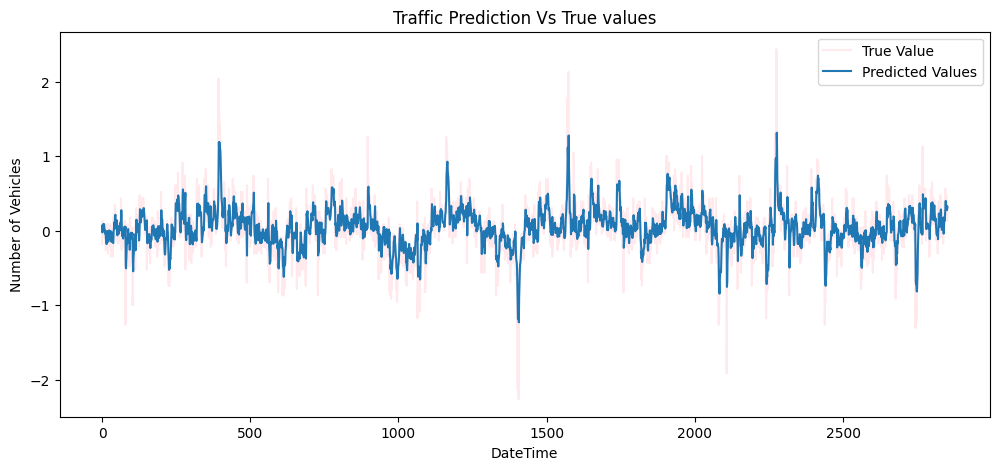

In [36]:
RMSE_BiLSTM = RMSE_Value(y_test, Pred_BiLSTM)
MAE_BiLSTM = MAE_Value(y_test, Pred_BiLSTM)
PredictionsPlot(y_test, Pred_BiLSTM, 0)

In [37]:
def LSTM_BiLSTM_model(X_Train, y_Train, X_Test, y_Test):

    # The combined LSTM, Bi-LSTM, and LSTM model
    model_LSTM_BiLSTM = Sequential()
    
    # Adding the first LSTM layer
    model_LSTM_BiLSTM.add(LSTM(units=100, return_sequences=True, activation='tanh', input_shape=(X_Train.shape[1], 1)))
    model_LSTM_BiLSTM.add(Dropout(0.2))
    
    # Adding a Bidirectional LSTM layer
    model_LSTM_BiLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True, activation='tanh')))
    model_LSTM_BiLSTM.add(Dropout(0.2))
    
    # Adding the second LSTM layer
    model_LSTM_BiLSTM.add(LSTM(units=20, activation='tanh'))
    model_LSTM_BiLSTM.add(Dropout(0.2))
    
    # Output layer
    model_LSTM_BiLSTM.add(Dense(units=1))

    # Compiling the model
    model_LSTM_BiLSTM.compile(optimizer=SGD(momentum=0.9), loss='mean_squared_error')
    
    # Fitting the model
    model_LSTM_BiLSTM.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120)
    
    # Making predictions
    pred_LSTM_BiLSTM = model_LSTM_BiLSTM.predict(X_Test)
    
    return pred_LSTM_BiLSTM

In [38]:
Pred_LSTM_BiLSTM = LSTM_BiLSTM_model(X_train,y_train,X_test, y_test)


Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0793 - val_loss: 0.0877
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0616 - val_loss: 0.0840
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0639 - val_loss: 0.0808
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0614 - val_loss: 0.0787
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0589 - val_loss: 0.0766
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0568 - val_loss: 0.0749
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0565 - val_loss: 0.0741
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0550 - val_loss: 0.0720
Epoch 9/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0544 - val_loss: 0.0702
Epoch 10/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0565 - val_loss: 0.0688
Epoch 11/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0513 - val_loss: 0.0678
Epoch 12/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0

The root mean squared error is 0.23826223408966976.
The MAE is 0.17210340973512012.


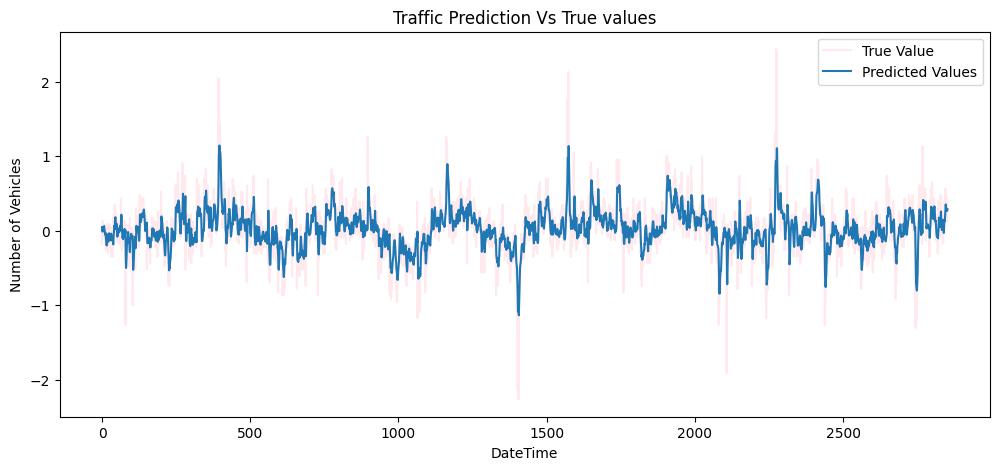

In [39]:
RMSE_LSTM_BiLSTM = RMSE_Value(y_test, Pred_LSTM_BiLSTM)
MAE_LSTM_BiLSTM = MAE_Value(y_test, Pred_LSTM_BiLSTM)
PredictionsPlot(y_test, Pred_LSTM_BiLSTM, 0)

In [40]:
# Tạo bảng so sánh các độ đo
data = {
    "Model": ["GRU", "LSTM", "BiLSTM", "LSTM + BiLSTM"],
    "RMSE": [RMSE_GRU, RMSE_LSTM, RMSE_BiLSTM, RMSE_LSTM_BiLSTM],
    "MAE": [MAE_GRU, MAE_LSTM, MAE_BiLSTM, MAE_LSTM_BiLSTM],
}

comparison_df = pd.DataFrame(data)

# Hiển thị bảng so sánh
print(comparison_df)

           Model      RMSE       MAE
0            GRU  0.234894  0.169399
1           LSTM  0.236665  0.170628
2         BiLSTM  0.234049  0.168710
3  LSTM + BiLSTM  0.238262  0.172103


Kết quả phân tích cho thấy rằng mô hình BİLSTM là mô hình hiệu quả nhất trong việc dự đoán giá trị của biến mục tiêu. Mô hình này có thể được sử dụng để dự đoán giá trị của biến mục tiêu trong các ứng dụng thực tế.